In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import warnings


In [2]:

# Ignore all warnings
warnings.filterwarnings("ignore")

# Or ignore a specific type of warning
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
df = pd.read_csv(r"C:\Users\albin\Downloads\archive\US_Accidents_March23.csv")

In [4]:
df.head(5)

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [5]:
df.isnull().sum()

ID                             0
Source                         0
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  3402762
End_Lng                  3402762
Distance(mi)                   0
Description                    5
Street                     10869
City                         253
County                         0
State                          0
Zipcode                     1915
Country                        0
Timezone                    7808
Airport_Code               22635
Weather_Timestamp         120228
Temperature(F)            163853
Wind_Chill(F)            1999019
Humidity(%)               174144
Pressure(in)              140679
Visibility(mi)            177098
Wind_Direction            175206
Wind_Speed(mph)           571233
Precipitation(in)        2203586
Weather_Condition         173459
Amenity                        0
Bump      

In [6]:
# Drop unusable columns
df = df.drop(columns=['End_Lat', 'End_Lng', 'Wind_Chill(F)', 'Precipitation(in)', 'Weather_Timestamp'])



In [7]:
# Handle missing locations (drop rows if lat/lng missing)
df = df.dropna(subset=['Start_Lat', 'Start_Lng'])


In [8]:

# For weather analysis, keep only rows with Weather_Condition
weather_df = df.dropna(subset=['Weather_Condition'])


In [9]:
df['Start_Time'] = df['Start_Time'].str.split('.').str[0]  # Remove everything after '.'
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['Hour'] = df['Start_Time'].dt.hour
df['DayOfWeek'] = df['Start_Time'].dt.day_name()


In [10]:
# Ensure Start_Time is datetime
df['Start_Time'] = pd.to_datetime(df['Start_Time'])

# Extract Hour and Day
df['Hour'] = df['Start_Time'].dt.hour
df['Day_of_Week'] = df['Start_Time'].dt.day_name()

In [11]:
# 1. Drop columns with too many missing values (as identified in your list)
cols_to_drop = ['End_Lat', 'End_Lng', 'Wind_Chill(F)', 'Precipitation(in)', 'Weather_Timestamp']
df = df.drop(columns=cols_to_drop, errors='ignore')

# 2. Drop rows with missing values in critical columns (City, Twilight, Weather)
# These represent a very small percentage of your ~7.7M rows
df = df.dropna(subset=['City', 'Sunrise_Sunset', 'Weather_Condition', 'Visibility(mi)', 'Temperature(F)'])

# 3. Standardize and Extract Time Features
# Handle inconsistent datetime formats and extract components
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df = df.dropna(subset=['Start_Time']) # Drop rows where time couldn't be parsed

df['Hour'] = df['Start_Time'].dt.hour
df['Day_of_Week'] = df['Start_Time'].dt.day_name()
df['Month'] = df['Start_Time'].dt.month_name()

print(f"Data cleaning complete. Remaining records: {len(df)}")

Data cleaning complete. Remaining records: 7488381


## EDA

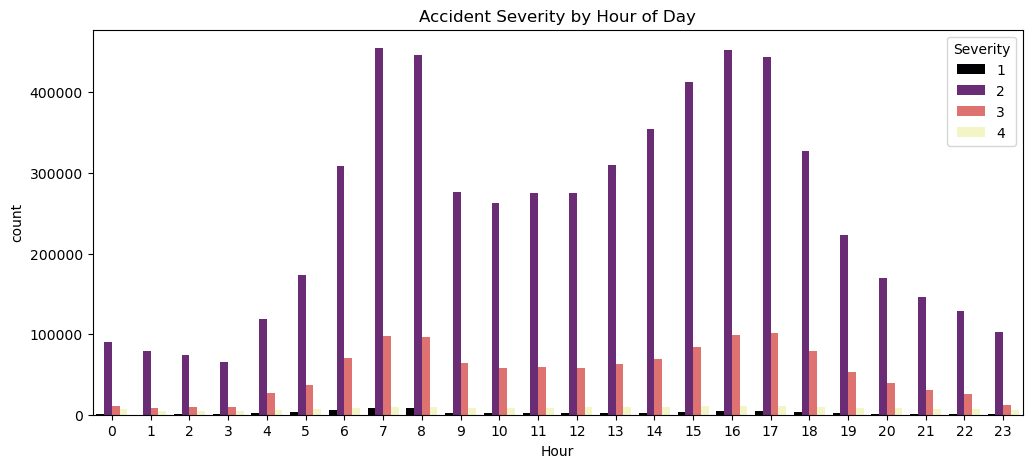

In [12]:
# --- Visualization 1: Time Patterns ---
plt.figure(figsize=(12, 5))
sns.countplot(x='Hour', data=df, hue='Severity', palette='magma')
plt.title("Accident Severity by Hour of Day")
plt.show()

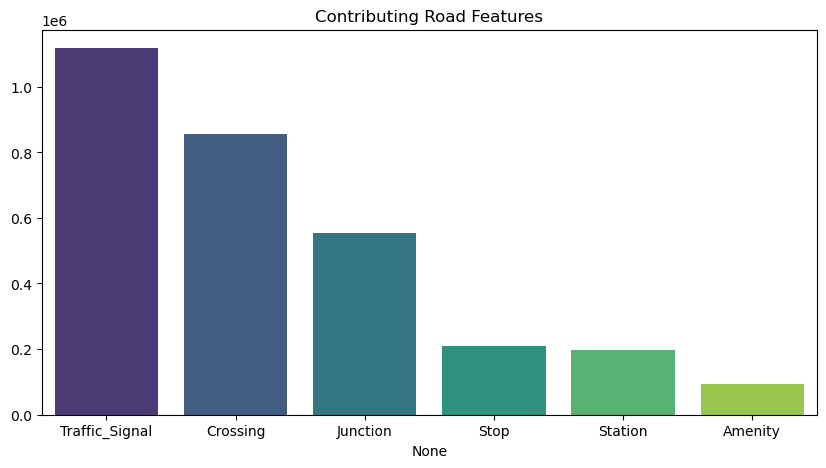

In [13]:
# --- Visualization 2: Road Conditions ---
road_features = ['Junction', 'Traffic_Signal', 'Crossing', 'Stop', 'Station', 'Amenity']
feature_counts = df[road_features].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_counts.index, y=feature_counts.values, palette='viridis')
plt.title("Contributing Road Features")
plt.show()


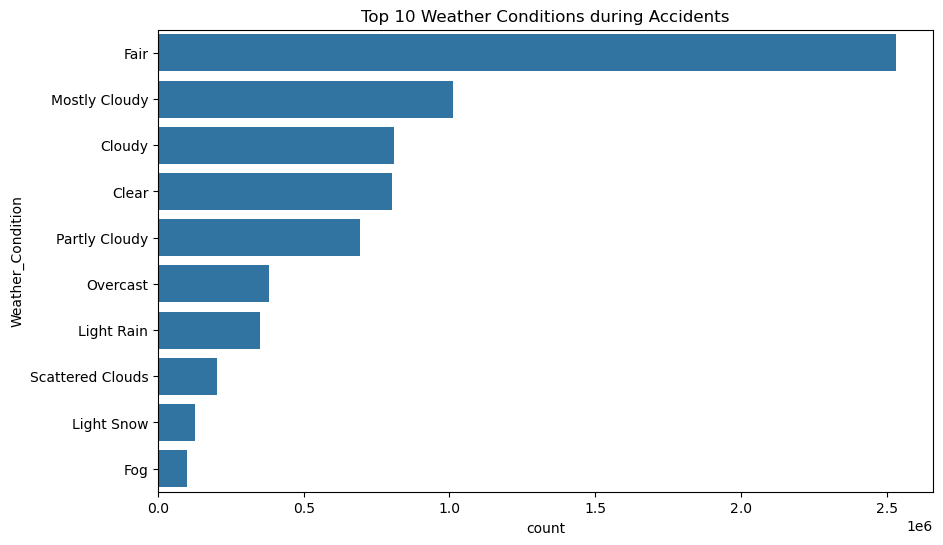

In [14]:
# --- Visualization 3: Weather Impact ---
top_10_weather = df['Weather_Condition'].value_counts().nlargest(10).index
plt.figure(figsize=(10, 6))
sns.countplot(y='Weather_Condition', data=df[df['Weather_Condition'].isin(top_10_weather)], order=top_10_weather)
plt.title("Top 10 Weather Conditions during Accidents")
plt.show()

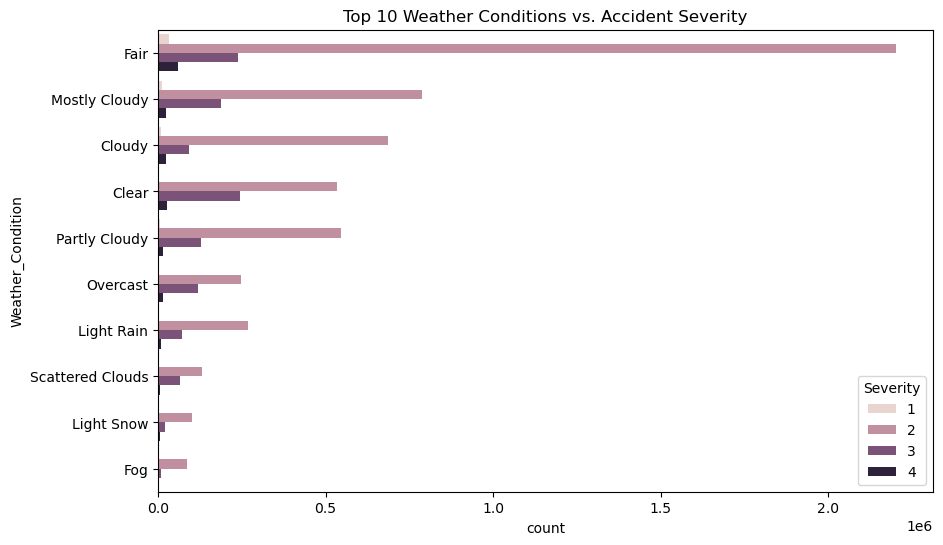

In [15]:
# Plot 3: Impact of Top 10 Weather Conditions
plt.figure(figsize=(10, 6))
top_weather = df['Weather_Condition'].value_counts().nlargest(10).index
sns.countplot(data=df[df['Weather_Condition'].isin(top_weather)], 
              y='Weather_Condition', hue='Severity', order=top_weather)
plt.title('Top 10 Weather Conditions vs. Accident Severity')
plt.show()

In [16]:
# Plot 4: Road Condition Contributing Factors (Junction, Crossing, etc.)
road_features = ['Junction', 'Traffic_Signal', 'Crossing', 'Stop', 'Station', 'Amenity']
# Summing the Boolean columns to get total counts
feature_counts = df[road_features].sum().sort_values(ascending=False)

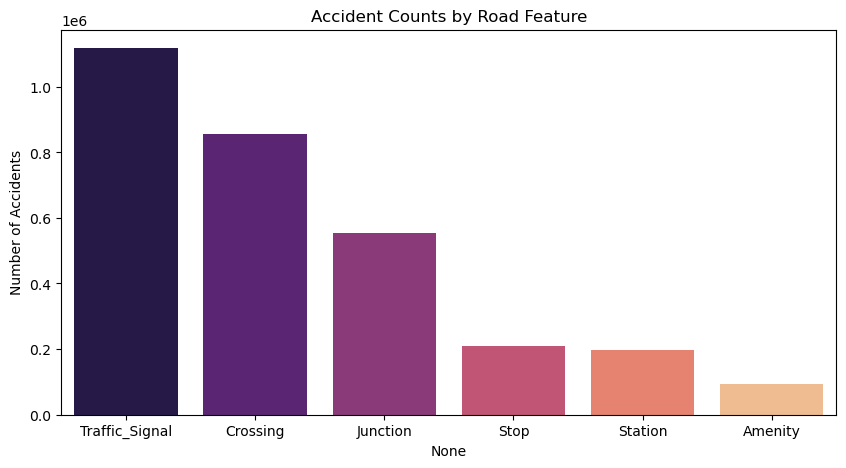

In [17]:
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_counts.index, y=feature_counts.values, palette='magma')
plt.title('Accident Counts by Road Feature')
plt.ylabel('Number of Accidents')
plt.show()

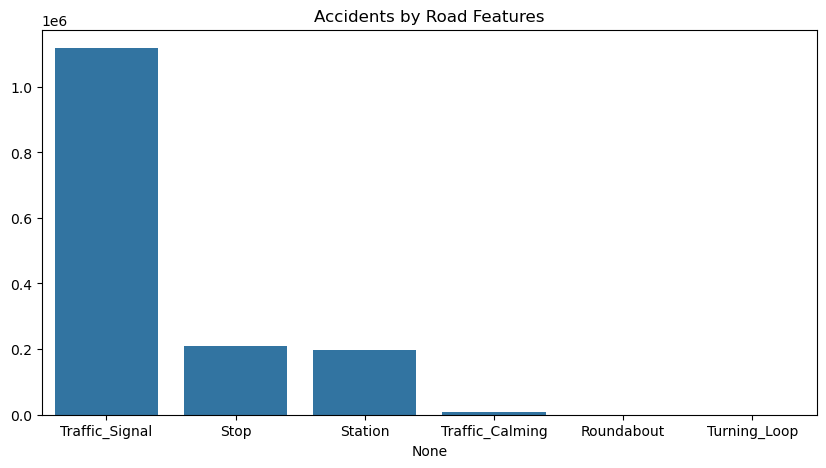

In [18]:
road_features = ['Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']
feature_counts = df[road_features].sum().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=feature_counts.index, y=feature_counts.values)
plt.title("Accidents by Road Features")
plt.show()


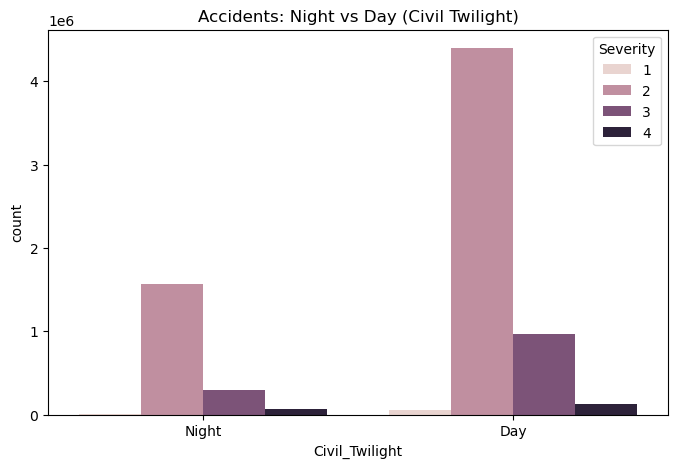

In [19]:
# Using the built-in Civil_Twilight column for comparison
plt.figure(figsize=(8,5))
sns.countplot(x='Civil_Twilight', data=df, hue='Severity')
plt.title("Accidents: Night vs Day (Civil Twilight)")
plt.show()

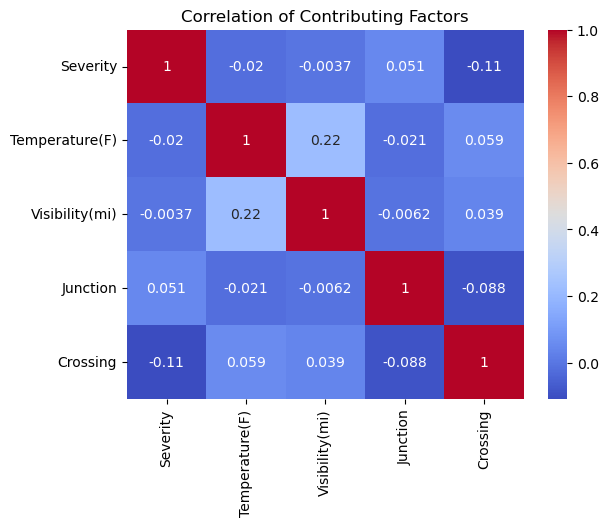

In [20]:
# 1. Correlation Heatmap
corr_cols = ['Severity', 'Temperature(F)', 'Visibility(mi)', 'Junction', 'Crossing']
sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation of Contributing Factors")
plt.show()

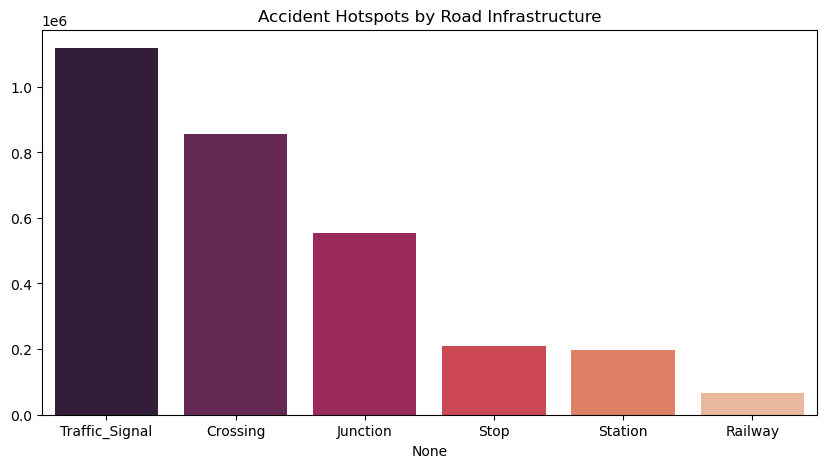

In [21]:
# 2. Road Condition Pattern (Adding more features)
road_features = ['Junction', 'Traffic_Signal', 'Crossing', 'Stop', 'Station', 'Railway']
feature_counts = df[road_features].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_counts.index, y=feature_counts.values, palette='rocket')
plt.title('Accident Hotspots by Road Infrastructure')
plt.show()

In [22]:
import folium
from folium.plugins import HeatMap

# Sample 10,000 rows for efficient mapping
map_data = df[['Start_Lat', 'Start_Lng']].dropna().sample(10000)

# Create a map centered on the US
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Prepare data and add Heatmap layer
heat_data = [[row['Start_Lat'], row['Start_Lng']] for index, row in map_data.iterrows()]
HeatMap(heat_data, radius=10).add_to(m)

# Save the map as an HTML file
m.save('accident_hotspots.html')
print("Hotspot map saved as 'accident_hotspots.html'.")

Hotspot map saved as 'accident_hotspots.html'.


In [24]:
# Save as a compressed zip file to save space
compression_opts = dict(method='zip', archive_name='Cleaned_Accidents.csv')  

df.to_csv('Cleaned_Accidents.zip', index=False, compression=compression_opts)

print("Compressed cleaned dataset saved as Cleaned_Accidents.zip")

Compressed cleaned dataset saved as Cleaned_Accidents.zip


## Conclusion
Transformed a massive dataset of 7.7 million traffic records into a meaningful story of road safety by first performing a rigorous data cleanup to remove millions of missing values and technical noise. By engineering new features from raw timestamps, then successfully mapped out the "pulse" of accidents, identifying peak danger zones during morning and evening rush hours and analyzing how severity fluctuates between day and night. Furthermore connected these incidents to their environmental causes, proving how infrastructure like junctions and specific weather patterns act as contributing factors. Finally, moved beyond abstract numbers to create a high-resolution geospatial heatmap that pinpointed physical accident hotspots across the country, turning a mountain of data into actionable visual insights.